# Analyzing NFL Pass Rush with Disguise Score

The goal of this project was to come up with a metric for how well an NFL defense coves up which players will rush the passer. There were three parts to this project:

* Use clustering to determine which pass rushers were unblocked on a play
* Build a model that can predict which players will rush the passer
* Calculate the metric and compare it against the number of free rushers on a play

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt;

import seaborn as sns
sns.set();

from sklearn.metrics import confusion_matrix

In [2]:
from CNN import print_baseline_accuracy

In [3]:
def load_data():
    plays = pd.read_csv("data/plays.csv")[['gameId', 'playId', 'down', 'yardsToGo', 'possessionTeam', 'defensiveTeam']]
    
    df_avg = pd.read_csv("df_avg_w_clusters.csv")
    df_flattened = pd.read_csv("df_flattened_w_preds.csv")
    tracking_merged = pd.read_csv("tracking_merged.csv")
    df_flattened = df_flattened.merge(plays[['gameId', 'playId', 'down', 'yardsToGo', 'possessionTeam', 'defensiveTeam']], 
                   on=['gameId', 'playId'])
    
    return plays, df_avg, df_flattened, tracking_merged

In [4]:
plays, df_avg, df_flattened, tracking_merged = load_data()

## Determining Free Rushers

The pata provided only specified the first player who was blocked by a given offensive lineman. So if an offensive lineman blocks a particular rusher on a double team and then moves on to another rusher, that wasn't captured in the data. So I used K-Means Clustering to split the data into two groups based on the player's average speed and average distance from the nearest blocker on the play.

As expected, the model finds that players with greater speed and greater distance from the nearest blocker tended to be free rushers. I spot checked the results using a play visualizer.

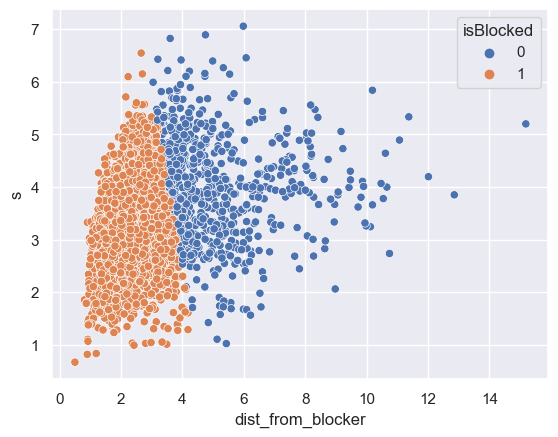

In [5]:
sns.scatterplot(x='dist_from_blocker', y='s', data=df_avg, hue='isBlocked');

## Predicting Pass Rushers

The next part of the project was to predict which defenders will rush the passer on a given play. To do this, I used a 2d convolutional neural network. The input was a 2 x 11 x 5 array.I had all 11 defenders in the first row and all 11 offensive players in the second row. Each player was lined up in order from left to right (from the perspective of the defense). The 5 channels were each player's x and y coordinate relative to the ball, speed, acceleration and direction.

The output layer had 11 neurons, one for each defender, and calculated a probability of that player rushing the passer.

As a baseline model, I found the four closest defenders to the ball at the time of the snap and predicted that they would rush the passer and no one else would. The neural network had a binary accuracy of 94.5% on a test set, which was better than the baseline accuracy of 81.5%. That means that about 5.5% of defenders in the test set were misclassified by my model.

In [6]:
test_metrics = pd.read_csv('test_metrics.csv').rename({'0': 'Accuracy'}, 
                                                      axis=1)[-11:][['Accuracy']]
print_baseline_accuracy(df_flattened)
print(f"Test Accuracy: {test_metrics['Accuracy'].mean()}")

Baseline Accuracy: 0.8146976090014064
Test Accuracy: 0.945305428721688


Since the neural network had a seperate output for each defender from left to right, we can see how it peformed on each one. It performed extremely well on the defenders furthest outside, which is to be expected. More often than not, that player would be an outside cornerback who rarely rushes that passer. More interestingly the hardest players to classify were the second furthest players on each side of the ball. That normally would be an outside linebacker, slot corner, or a strong safety.

In [7]:
test_metrics.index = [f"Defender {i+1}" for i in range(11)]
test_metrics.style.format({
                          "'Accuracy'":"${:20,.0f}"})\
                 .background_gradient(cmap='Reds')

,Accuracy
Defender 1,0.991798
Defender 2,0.924429
Defender 3,0.940832
Defender 4,0.937317
Defender 5,0.936731
Defender 6,0.947276
Defender 7,0.942589
Defender 8,0.937903
Defender 9,0.934388
Defender 10,0.920328


In [8]:
is_rusher = df_flattened[[f"isRusher_{i+1}" for i in range(11)]]
predictions = df_flattened[[f"prediction_{i+1}" for i in range(11)]]

In [9]:
num_rushers = is_rusher.sum(axis=1)
pred_num_rushers = np.round(predictions.values.sum(axis=1))

df_flattened['num_rushers'] = num_rushers
df_flattened['pred_num_rushers'] = pred_num_rushers

To better understand the behavior of the model, I plotted the redicted number of rushers next to the actual number of rushers for all plays. The model seemed to struggle with predictions when there were fewer than 4 or more than 5 rushers, as there were almost no predictions that included 3, 6, 7, or 8 rushers.

In the future, one way to help fix that issue would be to include more features, like down and distance or, which would put more context into the situation. Another possibility would be to engineer features related to the look the defense is showing. If we explicitly tell the model that there are no deep safeties, it may be easier for the model to guess that 6 or more players will rush the passer.

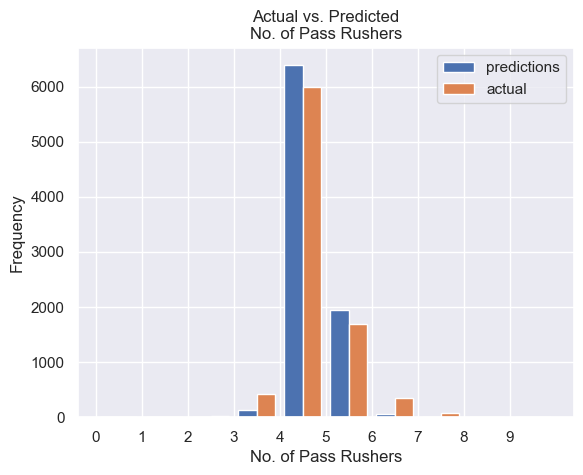

In [10]:
plt.figure()
bins = np.linspace(0, 10, 11)

plt.hist([pred_num_rushers, num_rushers], bins, label=['predictions', 'actual'])
plt.title("Actual vs. Predicted\nNo. of Pass Rushers")
plt.xlabel("No. of Pass Rushers")
plt.ylabel("Frequency")
plt.legend(loc='upper right');
plt.xticks(np.arange(0, 10, 1));

## Disguise Score

The final step of this project was to come up with a metric for how a defense diguises their pass rushers. I call the metric **Disguise Score** (Open to suggestions). Disguise Score works as follows:
* For each pass rusher on a given play, subtract their probability of rushing from one
* Add them all up and divide by the number of pass rushers
* Multiply by 100 to give a percentage

So theoretically the way to get a score of 100 on a play would be for the model to give all of your pass rushers a 0% chance of rushing on that play.

Below is a histogram of disguise score for all plays, and the average Disguise Score for all NFL defenses.

In [11]:
df_flattened = df_flattened[df_flattened['num_rushers'] > 2]

is_rusher = df_flattened[[f"isRusher_{i+1}" for i in range(11)]]
predictions = df_flattened[[f"prediction_{i+1}" for i in range(11)]]

num_rushers = is_rusher.sum(axis=1)

disguise_score = 100 * (is_rusher.values - predictions.values).clip(min=0).sum(axis=1)/num_rushers
df_flattened['disguise_score'] = disguise_score

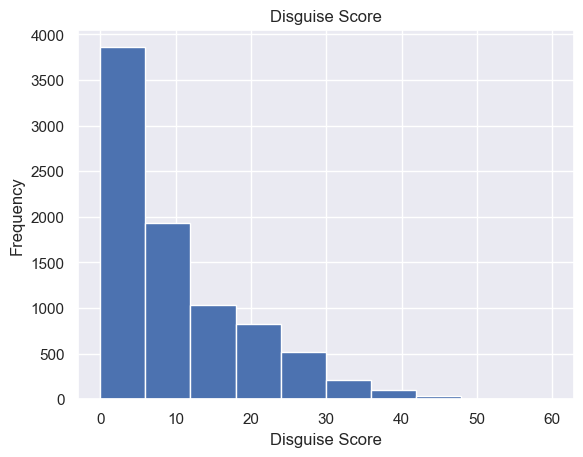

In [12]:
plt.hist(disguise_score)
plt.title("Disguise Score")
plt.xlabel("Disguise Score")
plt.ylabel("Frequency");

In [14]:
score_by_def_team = df_flattened.groupby('defensiveTeam').agg(np.mean)['disguise_score'].sort_values()

In [15]:
pd.DataFrame(score_by_def_team).style.format({
                          "'disguisesimulated_pressure_score'":"${:20,.0f}"})\
                 .format({"defensiveTeam": lambda x:x.lower(),
                          "EmployeeName": lambda x:x.lower()})\
                 .background_gradient(cmap='Reds')

,disguise_score
defensiveTeam,
LV,5.247980
PHI,6.693523
GB,7.798982
CLE,7.968485
HOU,7.970742
SF,8.597575
SEA,8.706753
LA,8.881074
LAC,9.211597


Lastly, we can add our analysis of unblocked pass rushers to Disguise Score to see the impact of successfully disguising your pass rush. We would expect that on plays with a high Disguise Score, defenses tended to have free rushers more often. As seen below, that generally was the case, even when adjusted for the total number of pass rushers on the play. That shows that Disguise score is a viable metric for how well a team does at being unpredictable with its pass rush.

In [16]:
rushers = tracking_merged[tracking_merged['isRusher'] == 1]
rushers = rushers[rushers['event']=='ball_snap']
rushers = rushers.merge(df_avg, how='left', on=['gameId', 'playId', 'nflId'])
rushers['isBlocked'].fillna(1, inplace=True)

rushers['numFreeRushers'] = 1 - rushers['isBlocked']

free_rushers = rushers.groupby(['gameId', 'playId'], 
                as_index=False).agg(np.sum)[['gameId', 'playId', 'numFreeRushers']]

df_flattened = df_flattened.merge(free_rushers, how='left', on=['gameId', 'playId'])

In [17]:
pressure_score_by_rushers = df_flattened.groupby(['num_rushers', 'numFreeRushers'], 
                     as_index=False).agg(np.mean)[['num_rushers', 'numFreeRushers', 'disguise_score']]

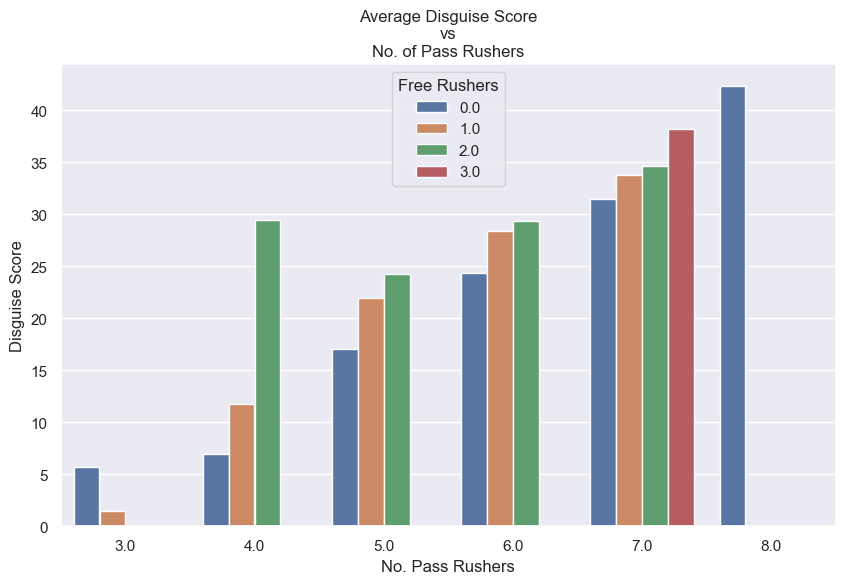

In [18]:
# Create the grouped bar chart
plt.figure(figsize=(10, 6))  # Set the figure size (optional)
sns.barplot(x="num_rushers", y="disguise_score", hue="numFreeRushers", data=pressure_score_by_rushers)

# Customize the plot
plt.title("Average Disguise Score\nvs\nNo. of Pass Rushers")  # Set the plot title
plt.xlabel("No. Pass Rushers")  # Set the x-axis label
plt.ylabel("Disguise Score")  # Set the y-axis label
plt.legend(title="Free Rushers")  # Set the legend title

# Display the plot
plt.show()